# Tutorial 01: How does SOBER work?
We will see the SOBER algorithm step by step

## 1. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from SOBER._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

### 1.1. GPU/CPU and float/double precision
In SOBER, torch.device and torch.dtype are pre-defined in SOBER._setting.py <br>
The pre-defined tensor types can be comfirmed by TensorManager instance. <br>

In [2]:
print(tm.device, tm.dtype)

cpu torch.float32


The device (CPU/GPU) is automatically changed based on torch.cuda.is_available() <br>
If you want to use CPU on GPU device, you need to define in "SOBER._setting.py" <br>
Similarly, the default of data type is torch.float.<br>
You can switch to torch.double in "SOBER._setting.py"<br>
In general, double precision yields better sample-efficiency but slower computation.<br>
Depends on the expensiveness of the tasks, you can change the precision.<br>

## 2. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [3]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

### 2.1 Visualise the function surface

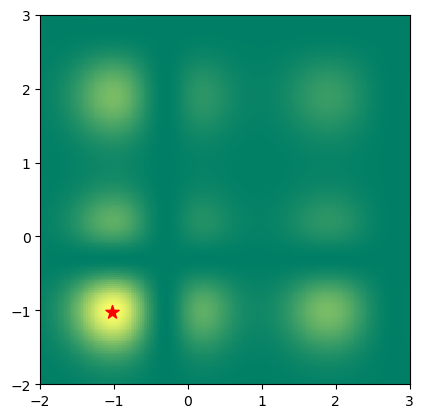

In [4]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

def get_plotting_domain():
    x = torch.linspace(lower_limit, upper_limit, resolution)
    y = torch.linspace(lower_limit, upper_limit, resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[lower_limit, upper_limit, lower_limit, upper_limit],
        interpolation='nearest',
        origin='lower',
    )
    ax.scatter(ground_truth[1], ground_truth[0], s=100, marker="*", color="red")

def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="white")

def plot_black(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="black")
    
fig, ax = plt.subplots()
Xgrid = get_plotting_domain()
Ygrid = BraninFunction(Xgrid)
plot_function(Ygrid, ax)
plt.show()

The red star is the ground truth. <br>
We can see 9 modals (9 peaks of Branin function).

### 2.2 Define the prior (domain)
We will define the prior distribution of global optimum location. <br>
If we know the global optimum location vaguely, we can inform it as the prior. <br>
In most cases, we don't know the global optimum location, so we use a non-informative prior, namely, the uniform prior. <br>
All we need to specify is the upper and lower bounds of the function. <br>
We know this is bounded from -2 to 3, so we set uniform prior as so.<br>

In [5]:
# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

Give it a try for random sampling from this prior.

In [6]:
n_init = 10          # number of initial samples
random_seed = 50     # random seed that determines random behaviours
torch.manual_seed(random_seed)

X = prior.sample(n_init) # random samples

Visualise the random samples from prior

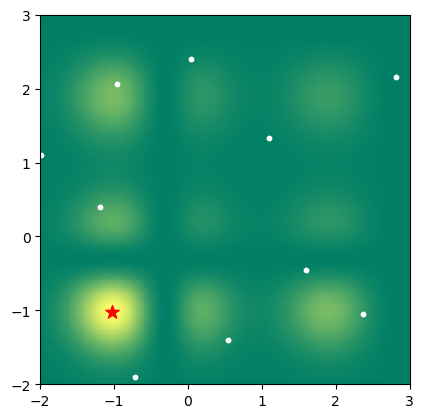

In [7]:
fig, ax = plt.subplots()
plot_function(Ygrid, ax)
plot_white(X, ax)
plt.show()

The white dots are the random samples from uniform prior. <br>
We can see that none of the samples hit the ground truth peak in the lower left. <br>
(If hit the ground truth, please change the random seed for explanation purpose.)

## 3. Modelling Gaussian process with GPyTorch
Next, we model the Gaussian process surrogate model as usual for Bayesian optimisation.<br>
We model Gaussian process with RBF kernel. <br>
We adopt type-II MLE to update the GP hyperparameter for simplicity.<br>

In [8]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model

def set_rbf_model(X, Y):
    """
    Set up the Gaussian process model with RBF kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    base_kernel = RBFKernel()
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    if tm.is_cuda():
        return model.cuda()
    else:
        return model

def optimise_model(model):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - model: gpytorch.models, the optimised GP model.
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

def predict(test_x, model):
    model.eval()
    model.likelihood.eval()

    try:
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = model.likelihood(model(test_x))
    except:
        warnings.warn("Cholesky failed. Adding more jitter...")
        with torch.no_grad(), gpytorch.settings.cholesky_jitter(float=1e-2):
            pred = model.likelihood(model(test_x))
    return pred.mean, pred.variance

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


We assume we have 10 initial samples. <br>
We optimise GP model for this initial samples. <br>

In [9]:
# initial samples
X = prior.sample(n_init)
Y = BraninFunction(X)
model = set_rbf_model(X, Y) # GP model with RBF kernel
model = optimise_model(model) # Optimise hyperparameters

visualise the "current" GP prediction

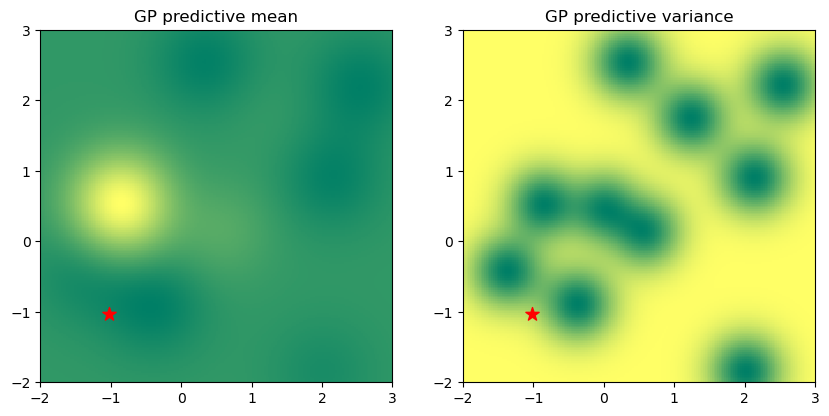

In [10]:
Ygrid_mean, Ygrid_var = predict(Xgrid, model) # posterior predictive distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_function(Ygrid_mean, ax1)
ax1.set_title("GP predictive mean")

plot_function(Ygrid_var, ax2)
ax2.set_title("GP predictive variance")
plt.show()

With given 10 initial samples, the GP is very uncertain. <br>
The predictive mean is not guiding to the global optimum location. <br>
The predictive variance is uniform and not guiding the exploration. <br>

## 4. Modelling SOBER-LFI
Now, we model SOBER. <br>
Actually, modelling has been almost done. <br>
Modelling SOBER is to model both $\pi$ and prior $\pi^\prime$. <br>
The prior $\pi^\prime$ is given by the users.
And the LFI $\pi$ is just transformation of GP as follows: <br>
$$
\pi(x) := \Phi \left[ \frac{m(x) - \eta}{\sqrt{C(x, x)}} \right]
$$
where $m(x)$ and $C(x,x)$ are the predictive mean and variance of GP, and $\eta := \max(\textbf{y}_\text{obs})$ is the "current" maximum of the observed y $\textbf{y}_\text{obs}$. <br>

In the SOBER library, $\pi$ is automatically computed when GP modell is passed. <br>
Let's visualise $\pi$.

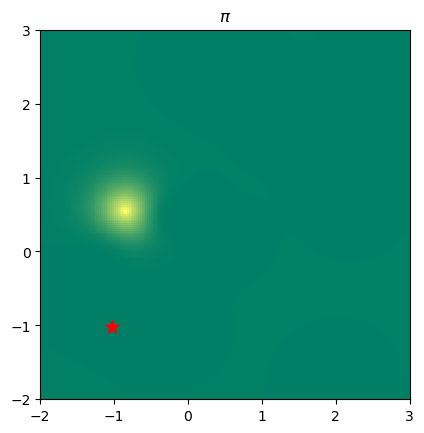

In [11]:
from SOBER._sober import Sober
sober = Sober(prior, model)

Ygrid_pi = sober.pi(Xgrid)  # sober.pi is the function of pi

fig, ax = plt.subplots()
plot_function(Ygrid_pi, ax)
ax.set_title("$\pi$")
plt.show()

Of course, this is not that different from predictive mean and posterior.

### 4.1 Sampling from $\pi$

Next, we sample from $\pi$. <br>
The sampling procedures are as follows:
1. sample from the prior $\pi^\prime$
2. compute the weights with $\pi$
3. optimise the sampler $\pi^\prime$ (kernel density estimation for continuous variabels)
4. resample from the optimised sampler.

Here, we need to decide how many samples we will draw from the prior $\pi^\prime$. <br>
Generally speaking, more samples contributes to more accurate sampling and slower comtutations. <br>
If time allows, larger samples are recommended, otherwise n_rec = 20000 is a good starting point.

In [12]:
n_rec = 20000      # number of candidates sampled from pi

X_cand, weights = sober.sampling(n_rec)              # 1st and 2nd step
sober.update_prior(X_cand, weights)                  # 3rd step
X_cand, weights = sober.recursive_sampling(n_rec)    # 4th step

Visualise the samples from $\pi$.

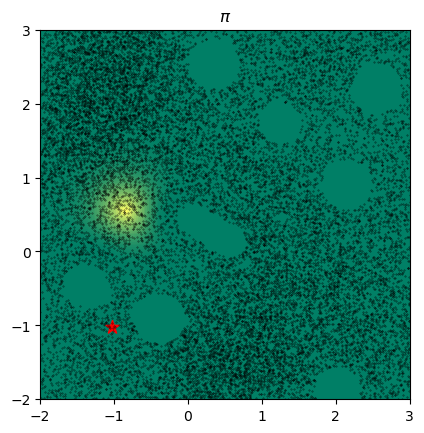

In [13]:
fig, ax = plt.subplots()
plot_function(Ygrid_pi, ax)
_X = tm.numpy(X_cand)    # transform to numpy
ax.scatter(_X[:,1], _X[:,0], s=0.1, alpha=0.8, color="black")
ax.set_title("$\pi$")
plt.show()

As we can see, the samples are spread over the domain, but concentrating around the peak of $\pi$.

## 4.2 Sparse sampling for Nyström approximation

Next, we draw samples for the Nyström approximation. <br>
This samples are used to approximate the GP function with sparse and fewer samples. <br>
So, sparsely sampling from $\pi$ is the desideratum. <br>
In SOBER, we adopt deweighted sampling, which resamples from the above samples with weights. <br>
Here, we also need to decide how many samples we will draw for Nyström approximation. <br>
Generally speaking, more samples contributes to more accurate sampling and slower comtutations. <br>
And the number of Nyström samples are smaller than the candidate samples, n_rec >> n_nys > batch_size. 
If time allows, larger samples are recommended, otherwise n_nys = 500 is a good starting point.

In [14]:
n_nys = 500        # number of samples for Nyström approximation

idx_nys = sober.deweighted_resampling(weights, n_nys) # deweighted sampling
X_nys = X_cand[idx_nys]

Visualise the deweighted samples

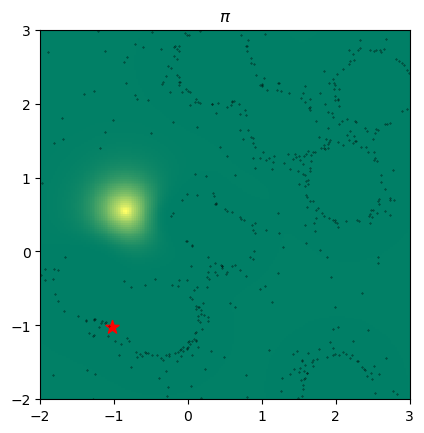

In [15]:
fig, ax = plt.subplots()
plot_function(Ygrid_pi, ax)
_X = tm.numpy(X_nys)    # transform to numpy
ax.scatter(_X[:,1], _X[:,0], s=0.1, alpha=0.8, color="black")
ax.set_title("$\pi$")
plt.show()

The samples are sparsely spread over the $\pi$.

## 4.3 Kernel recombination sampling (batch Bayesian optimization)

Finally, with the given models and samples, we select the batch querying locations. <br>
As the name of method implies, the kernel recombination can resample the sparse samples from X_cand under the kernel $K$. <br>
the kernel $K$ is the predictive covariance of GP. <br>
In the SOBER library, $K$ is automatically computed when GP modell is passed. <br>

In [16]:
sober.kernel

Next, we sepecify how many batch samples we will select. <br>
In this example, we set batch size = 30. <br>

In [17]:
batch_size = 30

Finally, we run the kernel recombination algorithm. <br>
We set no acquisition function for simplicity. <br>
We can set arbitrary acquisition function (see tutorial 03). <br>

In [18]:
acquisition_function = None

idx_batch, w_batch = sober.sampling_recombination(
    X_cand,
    X_nys,
    weights,
    batch_size,
    calc_obj=acquisition_function,
)
X_batch = X_cand[idx_batch]

Visualise the selected batch samples

In [19]:
def visualise_sober(Ygrid_pi, X, X_batch):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    plot_function(Ygrid_pi, ax1)
    plot_white(X, ax1)
    plot_black(X_batch, ax1)
    ax1.set_title("$\pi$", fontsize=20)
    
    plot_function(Ygrid, ax2)
    plot_white(X, ax2)
    plot_black(X_batch, ax2)
    ax2.set_title("true Branin function", fontsize=20)
    plt.show()

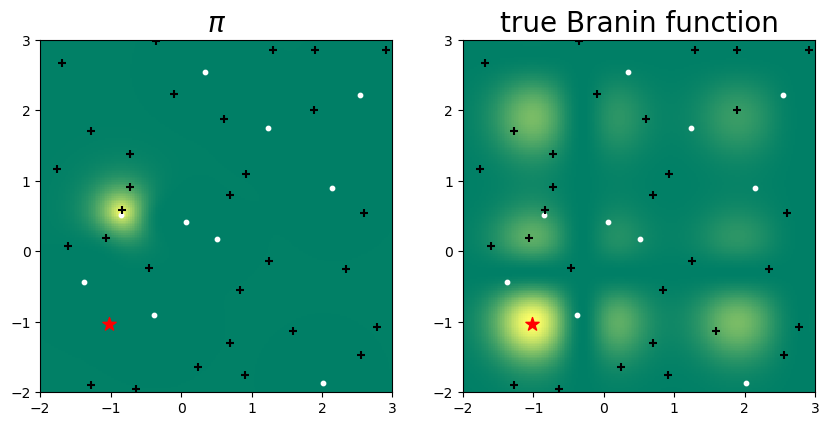

In [20]:
visualise_sober(Ygrid_pi, X, X_batch)

where the white dots are the previously selected samples (initial samples), and black crosses are the batch querying locations selected by the kernel recombination algorithm.

Kernel recombination algorithm can sparsely sample surprisingly well. <br>
But, why is this sparsified? The key is the quadrature. <br>
The kernel recombination is trying to estimate the following integral:
$$
    \int f_\text{true}(x) \text{d} \pi(x) \approx \sum_i^\text{batch_size} w_i f_\text{true}(x_i) 
$$
where $f_\text{true}$ is the true Branin function, and $\mathbb{E}[f(x)]$ is the predictive mean of GP surrogate model.

Let's comfirm this by comparing the values. <br>
The left hand side (LHS) can be approximated by weights and X_cand. <br>
The right hand side (RHS) is directly computable. <br>

In [21]:
LHS = weights @ BraninFunction(X_cand)
RHS = w_batch @ BraninFunction(X_batch)
integration_error = (LHS - RHS).abs().item()
print(LHS.item(), RHS.item())
print(integration_error)

1.4600613117218018 1.4600613117218018
0.0


As we can see, RHS is a good approximation of LHS. <br>
Kernel recombination can select the weights and samples that result in a provably small integration error. <br>

This can be understood to minimise the **Bayesian regret (BR)**.
$$
    \text{BR} := | y_\text{true}^* - \textbf{w}_\text{batch} f_\text{true}(\textbf{X}_\text{batch})|
$$
In other words, this is the regret of batch estimation of true global optimum $y_\text{true}^*$

In [22]:
y_true = tm.standardise_tensor(BraninFunction(ground_truth))
BR = (y_true - w_batch @ BraninFunction(X_batch)).abs()
print(BR.item())

9.144272804260254


This Bayesian regret and shrinkage of $\pi$ are known to have strong correlations. <br>
(See section 4 in the paper) <br>

The $\pi$ shrinkage can be computed as the mean variance (MV), as such:
$$
    \text{MV} := \textbf{w}_\text{rec} \text{diag} \left[
        (\textbf{X}_\text{rec} - \mathbb{E}[\pi(x)])^\top
        (\textbf{X}_\text{rec} - \mathbb{E}[\pi(x)])
    \right]
$$

In [23]:
pi_mean = weights @ X_cand
data_covariance = (X_cand - pi_mean) @ (X_cand - pi_mean).T
MV = weights @ data_covariance.diag()
print(MV.item())

1.0208791494369507


Over iterations, both BR and MV become smaller and smaller. <br>

# 5. Let's run!

In [24]:
def regret_analysis(w_batch, X_batch, weights, X_cand):
    # Bayesian regret
    BR = (y_true - w_batch @ BraninFunction(X_batch)).abs()
    
    # pi shrinkage
    pi_mean = weights @ X_cand
    data_covariance = (X_cand - pi_mean) @ (X_cand - pi_mean).T
    MV = weights @ data_covariance.diag()
    return BR, MV
    
def run_sober(sober, X, Y):
    model = set_rbf_model(X, Y) # GP model with RBF kernel
    model = optimise_model(model) # Optimise hyperparameters
    sober.update_model(model)
    
    # sampling from pi
    X_cand, weights = sober.sampling(n_rec)              # 1st and 2nd step
    sober.update_prior(X_cand, weights)                  # 3rd step
    X_cand, weights = sober.recursive_sampling(n_rec)    # 4th step
    
    # sampling for Nyström approximation
    idx_nys = sober.deweighted_resampling(weights, n_nys) # deweighted sampling
    X_nys = X_cand[idx_nys]
    
    # sampling for batch queries
    idx_batch, w_batch = sober.sampling_recombination(
        X_cand,
        X_nys,
        weights,
        batch_size,
        calc_obj=acquisition_function,
    )
    X_batch = X_cand[idx_batch]
    
    # regret analysis
    BR, MV = regret_analysis(w_batch, X_batch, weights, X_cand)    
    Ygrid_pi = sober.pi(Xgrid)
    visualise_sober(Ygrid_pi, X, X_batch)
    return sober, X_batch, BR, MV

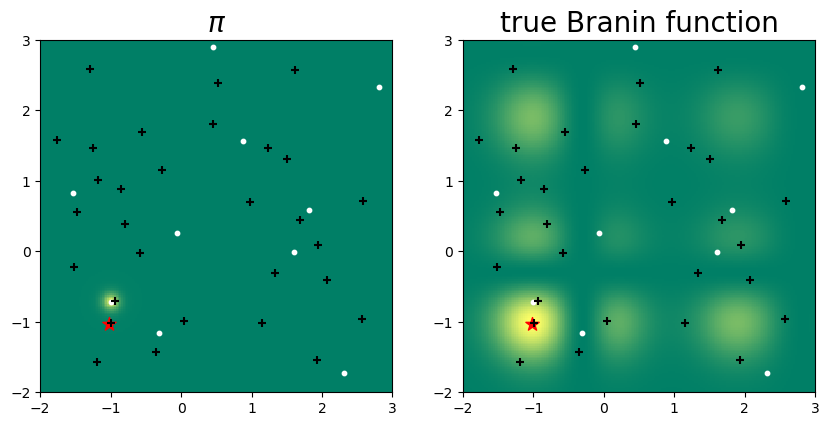

40) Best value: 1.05493e+01
Acquisition time [s]: 4.85627e+00, per sample [ms]: 1.61876e+02


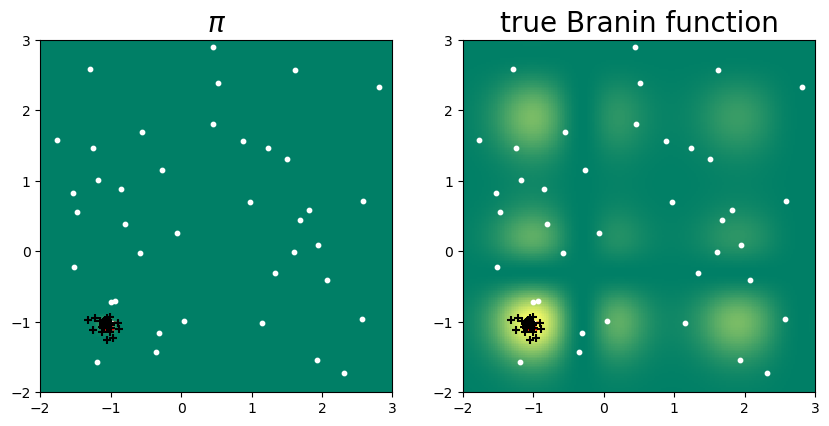

70) Best value: 1.06006e+01
Acquisition time [s]: 5.70205e+00, per sample [ms]: 1.90068e+02


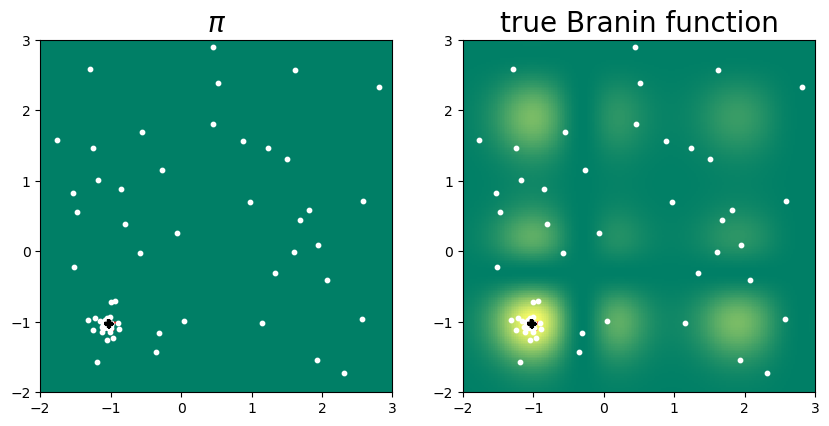

100) Best value: 1.06043e+01
Acquisition time [s]: 3.66651e+00, per sample [ms]: 1.22217e+02


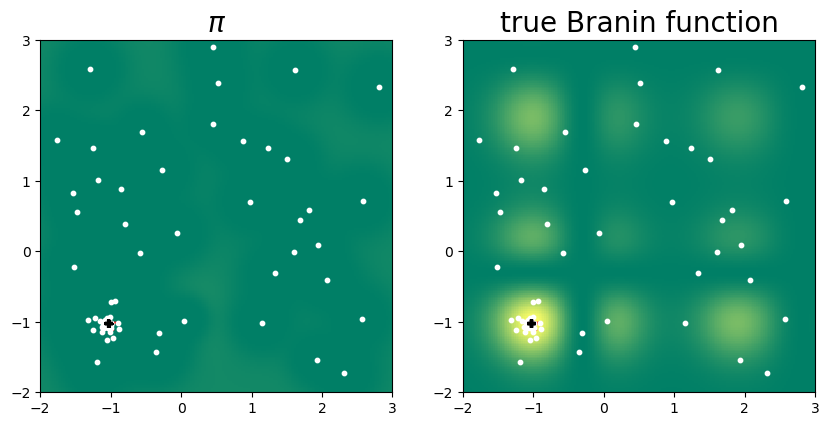

130) Best value: 1.06043e+01
Acquisition time [s]: 5.57722e+00, per sample [ms]: 1.85907e+02


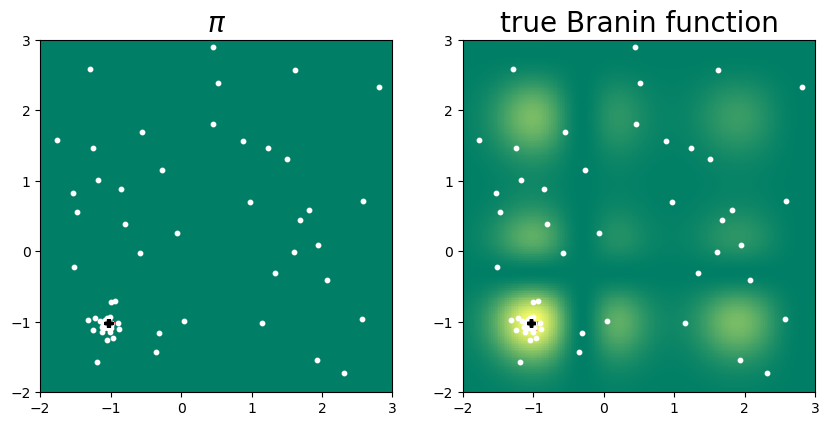

160) Best value: 1.06043e+01
Acquisition time [s]: 9.94546e+00, per sample [ms]: 3.31515e+02


In [25]:
batch_size = 30    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 10        # number of initial samples
n_iterations = 5   # number of iterations (batches)

# initial sampling
Xall = prior.sample(n_init)
Yall = BraninFunction(Xall)
model = set_rbf_model(Xall, Yall)
sober = Sober(prior, model)

results = []
for n_iter in range(n_iterations):
    start = time.monotonic()
    sober, X_batch, BR, MV = run_sober(sober, Xall, Yall)
    end = time.monotonic()
    interval = end - start
    
    Y_batch = BraninFunction(X_batch)
    Xall = torch.cat((Xall, X_batch), dim=0)
    Yall = torch.cat((Yall, Y_batch), dim=0)

    print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
    print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
    results.append([
        interval,          # the computational overhead
        Yall.max().item(), # the maximum
        BR.item(),         # Bayesian regret
        MV.item(),         # pi shrinkage
    ])

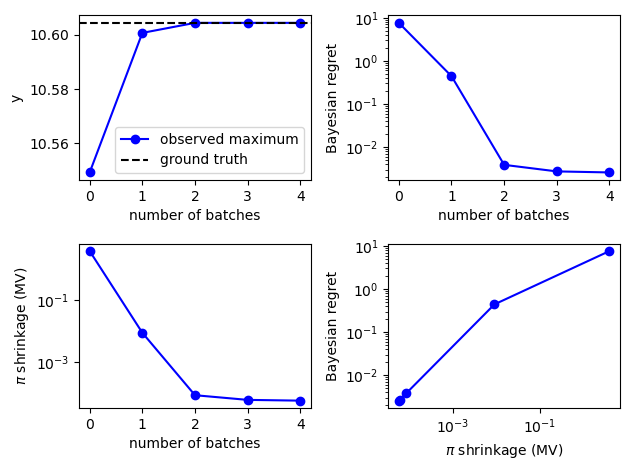

Correlation coefficient between BR and MV: 9.83809e-01


In [26]:
fig, axes = plt.subplots(2, 2, tight_layout=True)
idx_batch = torch.arange(n_iterations)
results = torch.tensor(results)
coeff = torch.corrcoef(results[:,2:].log().T)[0,1].item()

axes[0,0].plot(idx_batch, results[:,1], 'bo-', label="observed maximum")
axes[0,0].axhline(y=tm.numpy(y_true), linestyle="--", color="k", label="ground truth")
axes[0,0].legend()
axes[0,0].set_xlabel("number of batches")
axes[0,0].set_ylabel("y")

axes[0,1].plot(idx_batch, results[:,2], 'bo-')
axes[0,1].set_xlabel("number of batches")
axes[0,1].set_ylabel("Bayesian regret")
axes[0,1].set_yscale('log')

axes[1,0].plot(idx_batch, results[:,3], 'bo-')
axes[1,0].set_xlabel("number of batches")
axes[1,0].set_ylabel("$\pi$ shrinkage (MV)")
axes[1,0].set_yscale('log')

axes[1,1].plot(results[:,3], results[:,2], 'bo-')
axes[1,1].set_xlabel("$\pi$ shrinkage (MV)")
axes[1,1].set_ylabel("Bayesian regret")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')

plt.show()
print(f"Correlation coefficient between BR and MV: {coeff:.5e}")

## 6. Run SOBER as a module

In most cases, both regret analysis and visualisation are not required. <br>
We can run SOBER with the following simple codes in a modular manner. <br>
When **verbose** is enabled, we can see the detailed progress. <br>
We recommend this mode as it has more advanced functionalities to stabilise the learning processes. <br>

In [27]:
from SOBER._sober import Sober

seed = 0
torch.manual_seed(seed)  # random seed

batch_size = 30    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 10        # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

# initial sampling
Xall = prior.sample(n_init)
Yall = BraninFunction(Xall)
model = set_rbf_model(Xall, Yall)
sober = Sober(prior, model)

results = []
for n_iter in range(n_iterations):
    start = time.monotonic()
    model = set_rbf_model(Xall, Yall)   # GP model with RBF kernel
    model = optimise_model(model) # Optimise hyperparameters
    sober.update_model(model)     # pass the updated model to sober
    X_batch = sober.next_batch(
        n_rec,
        n_nys,
        batch_size,
        calc_obj=obj,
        verbose=True,
    )
    end = time.monotonic()
    interval = end - start
    
    Y_batch = BraninFunction(X_batch)
    Xall = torch.cat((Xall, X_batch), dim=0)
    Yall = torch.cat((Yall, Y_batch), dim=0)

    print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
    print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
    results.append([interval, Yall.max().item()])

--- generating the candidates from pi...
initial sampling...
update prior...
0-th recursive sampling...
--- Finished 5.542e+00 [s]
|| summary of sampling ||
 # of recombination samples: 1.985e+04
 # of Nyström samples: 5.000e+02
 # of nonzero weights: 1.970e+04
--- Start kernel recombination...
--- Finished all tasks 7.832e+00 [s]
40) Best value: 5.25935e+00
Acquisition time [s]: 7.96711e+00, per sample [ms]: 2.65570e+02
--- generating the candidates from pi...
initial sampling...
update prior...
0-th recursive sampling...
--- Finished 1.124e+01 [s]
|| summary of sampling ||
 # of recombination samples: 1.193e+04
 # of Nyström samples: 5.000e+02
 # of nonzero weights: 7.214e+03
--- Start kernel recombination...
--- Finished all tasks 1.209e+01 [s]
70) Best value: 1.02250e+01
Acquisition time [s]: 1.22164e+01, per sample [ms]: 4.07212e+02
--- generating the candidates from pi...
initial sampling...
update prior...
0-th recursive sampling...
--- Finished 4.754e+00 [s]
|| summary of sampl